In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Reshape, Lambda, Dense, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout, Activation
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#normalize the data
x_train = x_train/255.0
x_test = x_test/255.0

#one hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

FileNotFoundError: [Errno 2] No such file or directory: 'run/vae/0001_faces'

In [37]:
#Variational AutoEncoder class

class VAE():
    def __init__(self, input_shape,
                encoder_filters,
                encoder_kernel_size,
                encoder_strides,
                decoder_filters,
                decoder_kernel_size,
                decoder_strides,
                use_batchnorm,
                use_dropout,
                z_dim
                ):
        self.input_shape = input_shape
        self.encoder_filters = encoder_filters
        self.encoder_kernel_size = encoder_kernel_size
        self.encoder_strides = encoder_strides
        self.decoder_filters = decoder_filters
        self.decoder_kernel_size = decoder_kernel_size
        self.decoder_strides = decoder_strides
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        self.z_dim = z_dim
        self._build()
    
    def _build_encoder(self):
        #build the encoder model
        encoder_input = Input(shape=self.input_shape)
        x = encoder_input
        for i in range(len(self.encoder_filters)):
            x = Conv2D(filters=self.encoder_filters[i],
                      kernel_size=self.encoder_kernel_size[i],
                      strides=self.encoder_strides[i],
                      padding='same')(x)
            if self.use_batchnorm:
                x = BatchNormalization()(x)
            
            x = LeakyReLU()(x)
            
            if self.use_dropout:
                x = Dropout(rate=0.5)(x)
        
        self.shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        encoder_mu = Dense(self.z_dim)(x)
        encoder_log_var = Dense(self.z_dim)(x)
        encoder_intermediate_model = Model(encoder_input, (encoder_mu, encoder_log_var))
        
        def sample(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0.0, stddev=1.0)
            z = mu + K.exp(log_var/2)*epsilon
            return z
        
        sampling_layer = Lambda(sample)([encoder_mu, encoder_log_var])
        encoder_output = sampling_layer
        encoder_model = Model(encoder_input, encoder_output)
        
        return encoder_input, encoder_output, encoder_mu, encoder_log_var, encoder_intermediate_model, encoder_model
    
    def _build_decoder(self):
        
        decoder_input = Input(shape=(self.z_dim,))
        x = Dense(np.prod(self.shape_before_flattening))(decoder_input)
        x = Reshape(self.shape_before_flattening)(x)
        
        for i in range(len(self.decoder_filters)):
            x = Conv2DTranspose(filters=self.decoder_filters[i],
                           kernel_size=self.decoder_kernel_size[i],
                           strides=self.decoder_strides[i],
                           padding='same')(x)
            
            if i < len(self.decoder_filters)-1:
                if self.use_batchnorm:
                    x = BatchNormalization()(x)

                x = LeakyReLU()(x)

                if self.use_dropout:
                    x = Dropout(rate=0.5)(x)
            else:
                x = Activation('sigmoid')(x)
                
        decoder_output = x
        
        decoder_model = Model(decoder_input, decoder_output)
        
        return decoder_input, decoder_output, decoder_model
                
        
            
    
    def _build(self):
        #build the encoder and decoder models
        
        self.encoder_input, \
        self.encoder_output, \
        self.encoder_mu, \
        self.encoder_log_var, \
        self.encoder_intermediate_model, \
        self.encoder_model = self._build_encoder()
        
        self.decoder_input, \
        self.decoder_output, \
        self.decoder_model = self._build_decoder()
        
        #build the VAE model from the above two pieces
        model_output = self.decoder_model(self.encoder_output)
        self.model = Model(self.encoder_input, model_output)
        
    def compile(self, learning_rate, r_loss_factor=1000):
        
        def vae_r_loss(y_true, y_pred):
            return K.mean(K.square(y_true-y_pred), axis=[1,2,3])
        
        def vae_kl_loss(y_true, y_pred):
            kl_loss =  -0.5 * K.sum(1 + self.encoder_log_var - K.square(self.encoder_mu) - K.exp(self.encoder_log_var), axis = 1)
            return kl_loss
        
        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred) * r_loss_factor
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss
        
        self.model.compile(loss=vae_loss, optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
        
    def train(self,x_train, batch_size, epochs):
        self.model.fit(x_train, x_train, batch_size=batch_size, epochs=epochs)
        
    
        

In [38]:
vae = VAE(input_shape=x_train.shape[1:],
                 encoder_filters=[32, 32, 64, 64], 
                 encoder_kernel_size = [3, 3, 3, 3],
                 encoder_strides=[1, 2, 2, 1],
                 decoder_filters=[64, 32, 32, 3],
                 decoder_kernel_size=[3, 3, 3, 3],
                 decoder_strides=[1, 2, 2, 1],
                use_batchnorm=False,
                use_dropout=False,
                z_dim=20)

In [39]:
vae.encoder_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_28 (LeakyReLU)      (None, 32, 32, 32)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 16, 16, 32)   9248        leaky_re_lu_28[0][0]             
___________________________________________________________________________________________

In [40]:
vae.encoder_intermediate_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_28 (LeakyReLU)      (None, 32, 32, 32)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 16, 16, 32)   9248        leaky_re_lu_28[0][0]             
___________________________________________________________________________________________

In [41]:
vae.decoder_model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 4096)              86016     
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 16, 16, 32)        18464     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 16, 16, 32)        0  

In [42]:
vae.compile(learning_rate=0.001, r_loss_factor=1000)

In [ ]:
vae.train(x_train, batch_size=32, epochs=50)

Epoch 1/50
50000/50000 [==============================] - 38s 768us/sample - loss: 37.3865 - acc: 0.5210
Epoch 2/50
50000/50000 [==============================] - 44s 881us/sample - loss: 34.6755 - acc: 0.5643
Epoch 3/50
50000/50000 [==============================] - 42s 842us/sample - loss: 34.3653 - acc: 0.5658
Epoch 4/50
50000/50000 [==============================] - 41s 824us/sample - loss: 34.2430 - acc: 0.5662
Epoch 5/50
50000/50000 [==============================] - 42s 842us/sample - loss: 34.1439 - acc: 0.5678
Epoch 6/50
50000/50000 [==============================] - 47s 946us/sample - loss: 34.0411 - acc: 0.5697
Epoch 7/50
50000/50000 [==============================] - 47s 948us/sample - loss: 34.0320 - acc: 0.5716
Epoch 8/50
50000/50000 [==============================] - 49s 971us/sample - loss: 33.9544 - acc: 0.5710
Epoch 9/50
50000/50000 [==============================] - 50s 993us/sample - loss: 33.8963 - acc: 0.5710
Epoch 10/50
50000/50000 [==============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



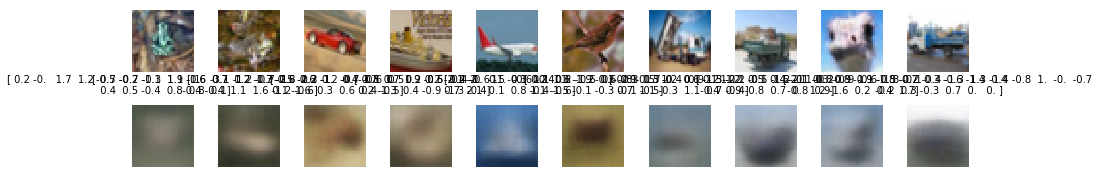

In [48]:
#reconstruct inputs from test set
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = vae.encoder_model.predict(example_images)

reconst_images = vae.decoder_model.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')
